In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Torch does computations using directed cyclic graphs
# Each operation typically creates an intermediate node
# we can work through a simple example

# 2 * (a - b) + c
# r1 = a - b
# r2 = 2 * r1
# output = r2 + c
def compute_abc(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    out = torch.add(r2, c)
    return out

print('Scalar Inputs:', compute_abc(torch.tensor(1), torch.tensor(2), torch.tensor(3)))
print('Rank 1 Inputs:', compute_abc(torch.tensor([1]), torch.tensor([2]), torch.tensor([3])))
print('Rank 2 Inputs:', compute_abc(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))

Scalar Inputs: tensor(1)
Rank 1 Inputs: tensor([1])
Rank 2 Inputs: tensor([[1]])


In [3]:
# To create model parameters that require gradient updates, requires grad must be True
a = torch.tensor(33.)
print(a)
a = torch.tensor(33., requires_grad=True)
print(a)

# To simply update this status, we can use the requires_grad_ method
# Methods that modify in-place typically end in an underscore in pytorch
b = torch.tensor([1., 2., 3.])
print(b)
b.requires_grad_()
print(b)

tensor(33.)
tensor(33., requires_grad=True)
tensor([1., 2., 3.])
tensor([1., 2., 3.], requires_grad=True)


If the weights of every layer are equal, by symmetry the updates to every weight in a layer will be identical. This requires an initialization of weights to be non-identical. This is usually done with randomization, using various distributions to initialize.

A popular initialization of the weights is known as Xavier (or Glorot) initialization. Random uniform or normal initialization can often result in poor results. The Xavier initialization can work with both normal and uniform distributions. For a set of weights that multiply into $n_{in}$ neurons, and $n_{out}$ is the number of output neurons that feed into the next layer. The distributions are then $$Xavier_{uniform} \sim U\left(- \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}} \right), \quad Xavier_{normal} \sim N\left(\mu =0, \sigma^2 = \frac{2}{n_{in} + n_{out}}\right)$$

This allows for the variance of the gradients across different layers to be balanced.

In [4]:
# Implementing the initialization
class ExampleModule(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)

# These tensors will initialize with a Xavier normal distribution
# They can be updated with automatic differentiation

Automatic differentiation is a computational technique to implement the chain rule. Consider the following setup: $$ u_0 = x, \\ u_1 = h(u_0), \\ u_2 = g(u_1) \\ y = u_3 = f(u_2).$$
The 2 major techniques to compute this are forward accumulation, $$\frac{dy}{dx} = \frac{du_3}{du_2}\frac{du_2}{du_0}, \dots,$$ and reverse accumulation $$\frac{dy}{dx} = \frac{du_3}{du_1}\frac{du_1}{du_0}, \dots$$

PyTorch uses reverse accumulation, which is more efficient for backpropagation. The results are identical, but reverse accumulation starts by computing the derivative at the first layer, while forward accumulation starts by computing it at the last layer.

In [5]:
# Automatic differentiation for a simple y = w x + b model with MSE loss
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)
x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w, x), b)
loss = (y-z).pow(2).sum()
loss.backward()
print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

# Calculate the automatic differentiation for w and b to compare
print(2 * x * ((w * x + b) - y))
print(2 * ((w * x + b) - y))

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)
tensor([-0.5600], grad_fn=<MulBackward0>)
tensor([-0.4000], grad_fn=<MulBackward0>)


In [6]:
# nn.Sequential is a simple way to build a neural network
# If it is simply layer3(layer2(layer1(x))) (i.e. densely connected)
# This allows us to skip the definition of the forward step, which becomes auto-implemented
# This builds on nn.Module (and is a subclass)

model = nn.Sequential(nn.Linear(4, 16),
                      nn.ReLU(),
                      nn.Linear(16, 32),
                      nn.ReLU()
                      )
print(model)

# This can be further customized with various intializations, or L_p regularizations
nn.init.xavier_uniform_(model[0].weight)

l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()


# Loss functions depend entirely on the problem at hand
# In this example, we will go with a Binary Cross Entropy loss, assuming that the task is binary classification
# AUCROC, Precision and Recall 
loss_fn = nn.BCELoss()

# Popular optimizers are ADAM and SGD
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)


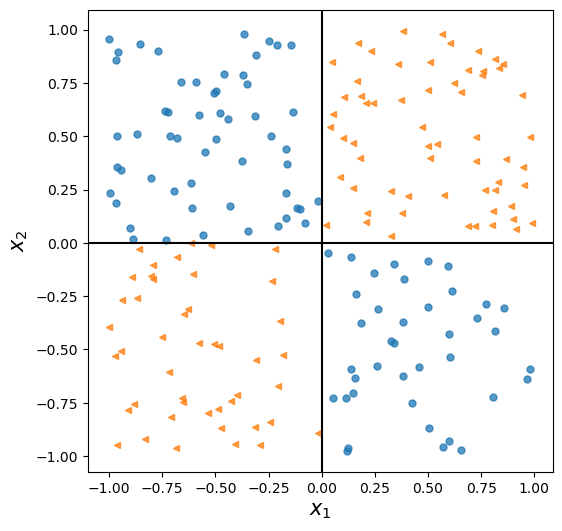

In [7]:
# Let's now use this classifier on an XOR dataset

torch.manual_seed(1)
np.random.seed(1)


x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))

y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100

x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)

x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)


fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=5)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=5)

plt.axhline(0, color="black")
plt.axvline(0, color="black")

plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [8]:
# Logistic regression model
model = nn.Sequential(nn.Linear(2, 1), nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Create Dataloaders
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [9]:
# Training loop
num_epochs = 300

def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train, loss_hist_valid = [0] * num_epochs, [0] * num_epochs
    acc_hist_train, acc_hist_valid = [0] * num_epochs, [0] * num_epochs

    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            
            loss = loss_fn(pred, y_batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()
            correct_preds = ((pred >= 0.5).float() == y_batch).float()
            acc_hist_train[epoch] += correct_preds.mean()
        
        loss_hist_train[epoch] /= n_train / batch_size
        acc_hist_train[epoch] /= n_train / batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)

        loss_hist_valid[epoch] = loss.item()
        correct_preds = ((pred >= 0.5).float() == y_valid).float()
        acc_hist_valid[epoch] += correct_preds.mean()

    return loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid

hist = train(model=model, num_epochs=num_epochs, train_dl=train_dl, x_valid=x_valid, y_valid=y_valid)

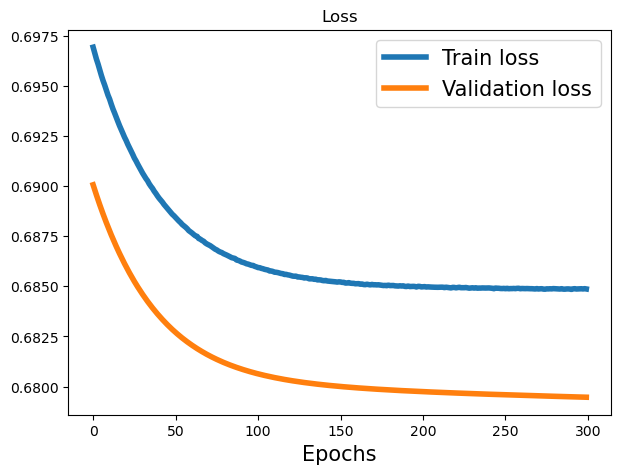

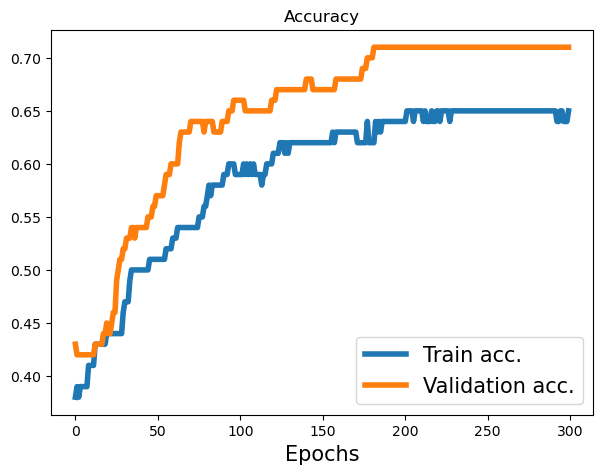

In [10]:
plt.figure(figsize=(7, 5))
plt.plot(hist[0], lw=4)
plt.plot(hist[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
plt.xlabel('Epochs', size=15)
plt.title('Loss')
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(hist[2], lw=4)
plt.plot(hist[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
plt.xlabel('Epochs', size=15)
plt.title('Accuracy')
plt.show()

In [11]:
# The simple logistic regressor could not deal with a non-linear dataset since it uses a simple linear boundary
# The universal approximation theorem suggests that a feedforward NN with a relatively large number of hidden layers and units can approximate any arbitrary continuous function

model = nn.Sequential(
nn.Linear(2, 4),
nn.ReLU(),
nn.Linear(4, 4),
nn.ReLU(),
nn.Linear(4, 1),
nn.Sigmoid()
)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
print(model)

hist = train(model=model, num_epochs=num_epochs, train_dl=train_dl, x_valid=x_valid, y_valid=y_valid)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)


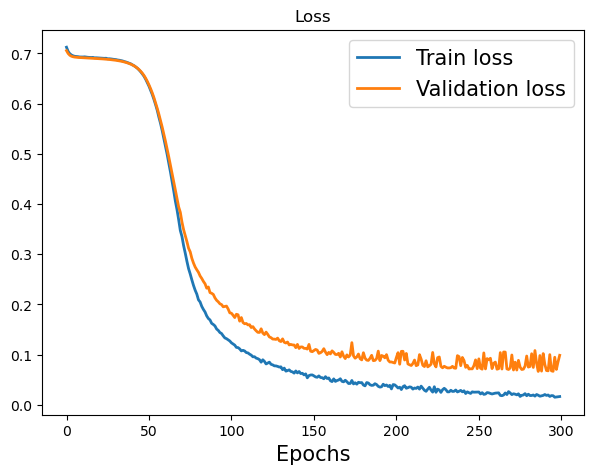

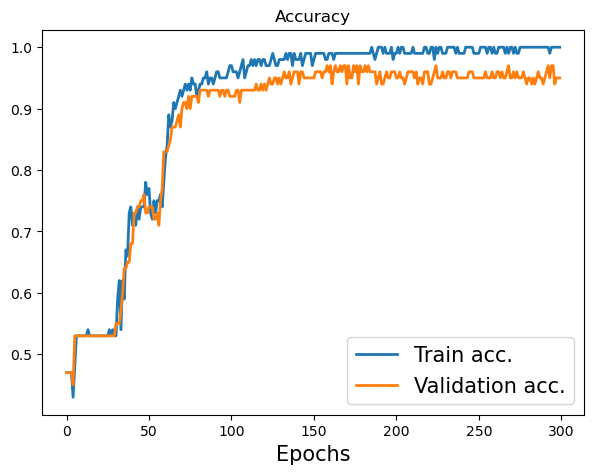

In [12]:
plt.figure(figsize=(7, 5))
plt.plot(hist[0], lw=2)
plt.plot(hist[1], lw=2)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
plt.xlabel('Epochs', size=15)
plt.title('Loss')
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(hist[2], lw=2)
plt.plot(hist[3], lw=2)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
plt.xlabel('Epochs', size=15)
plt.title('Accuracy')
plt.show()

In [21]:
# We can also have a more customized network by subclassing nn.Module
class ExampleModule(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()

        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)
    
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()

In [22]:
model = ExampleModule()
print(model)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

hist = train(model=model, num_epochs=num_epochs, train_dl=train_dl, x_valid=x_valid, y_valid=y_valid)

ExampleModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


C:\Users\sadit\AppData\Local\Temp\ipykernel_10656\503975795.py:16: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y=y_valid.numpy().astype(np.integer),


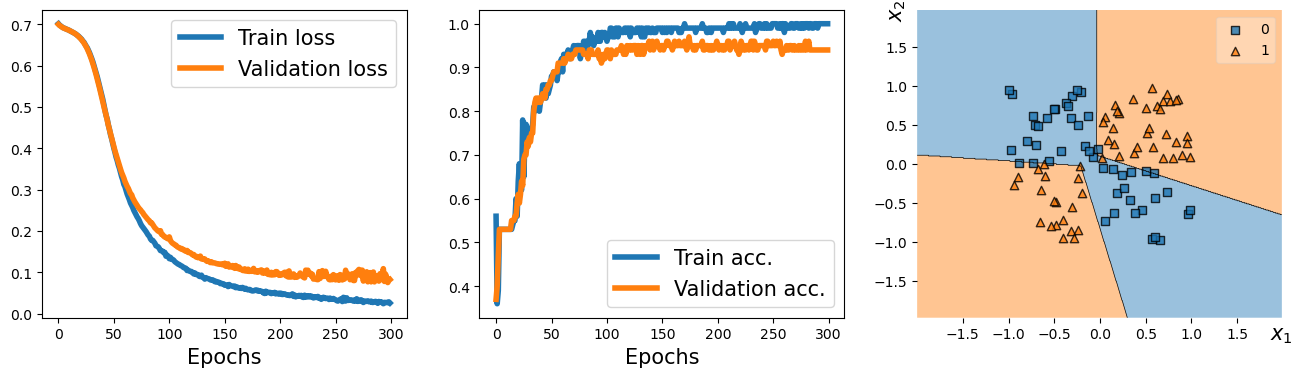

In [23]:
from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(hist[0], lw=4)
plt.plot(hist[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 2)
plt.plot(hist[2], lw=4)
plt.plot(hist[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(),
y=y_valid.numpy().astype(np.integer),
clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

In [ ]:
# We can also write custom layers for neural networks by subclassing nn.Module
# In this example, we will use a model for a noisy linear model: y = w (x + N(0, stdev^2)) + b
# This can be implmented as a noisy linear model

class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1) -> None:
        super().__init__()
        
        self.w = nn.Parameter(torch.Tensor(input_size, output_size))
        nn.init.xavier_uniform_(self.w)

        self.b = nn.Parameter(torch.Tensor(output_size).fill_(0))

        self.sigma = noise_stddev
    
    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.sigma, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)

# Usage example:

noisy_layer = NoisyLinear(4, 2)
x_inp = torch.zeros((1, 4))
for i in range(3):
    print(noisy_layer(x_inp, training=True))
    
print(noisy_layer(x_inp, training=False))

tensor([[-0.0572, -0.2804]], grad_fn=<AddBackward0>)
tensor([[0.0561, 0.0422]], grad_fn=<AddBackward0>)
tensor([[-0.0474,  0.0359]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [35]:
# Build on this to work through the XOR example with a noisy classifier
class NoisyModule(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        # Now the noisy linear layer is used as a first layer
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()

        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()

        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
        
        # # Omit l1 since that needs an additional "training" input
        # l = [self.a1, self.l2, self.a2, self.l3, self.a3]
        # self.module_list = nn.ModuleList(l)

    def forward(self, x, training=False):
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()

torch.manual_seed(42)
model = NoisyModule()

print(model)

NoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)


In [36]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

num_epochs = 300

loss_hist_train = [0] * num_epochs
acc_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
acc_hist_valid = [0] * num_epochs


for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        acc_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    acc_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    acc_hist_valid[epoch] += is_correct.mean()

C:\Users\sadit\AppData\Local\Temp\ipykernel_10656\4029040906.py:13: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.integer), clf=model)


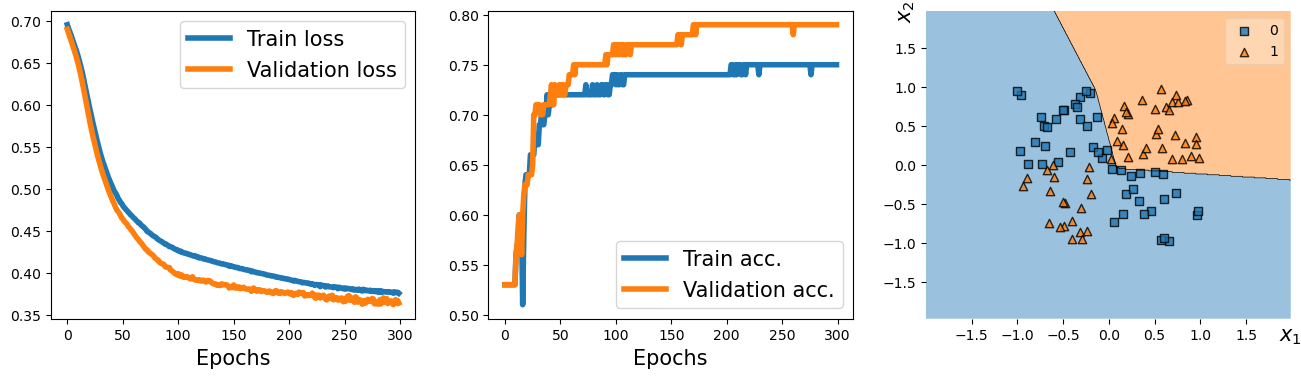

In [37]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 2)
plt.plot(acc_hist_train, lw=4)
plt.plot(acc_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.integer), clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

This didn't actually improve the accuracy of the predictor, but did demonstrate the use of a custom layer in the module.